In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt

import glob
from glob import glob
import nibabel as nb

C:\Users\Xiaowei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Xiaowei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [3]:
print(torch.version.cuda)

10.2


In [4]:
torch.cuda.is_available()

True

In [3]:
from dataclasses import dataclass

@dataclass
class Parameters:
    bs : int
    n_channels : int
    ngf : int
    ndf : int
    size : int
    gen_n_down : int
    gen_n_blocks : int
    dis_n_down : int

p = Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=6, dis_n_down=2)

In [4]:
mri_file = glob(r"C:\Users\Xiaowei\Documents\MRI_Vols\100610\m100610_T1w.nii.gz")[0]
mri_im = nb.load(mri_file)
mri_data = mri_im.get_fdata()

sos_file = glob(r"C:\Users\Xiaowei\Documents\MRI_Vols\100610\Vp.nii.gz")[0]
sos_im = nb.load(sos_file)
sos_data = sos_im.get_fdata()

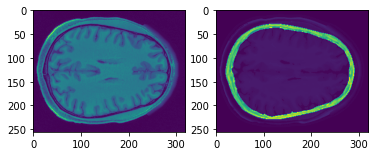

In [5]:
slice = 180
m = mri_data[:,:,slice]
s = sos_data[:,:,slice]

plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(m)
plt.subplot(1,2,2)
plt.imshow(s)

In [6]:
def filter(m,s,T):
    temp_m = np.array(m).flatten()
    temp_s = np.array(s).flatten()

    fil_m = []
    fil_s = []

    for x in range(temp_s.shape[0]):
        if(not np.isnan(T[0])) and (np.isnan(T[1])): #only filtering downwards
            # print("filtering downwards")
            if(temp_s[x] > T[0]):
                fil_m.append(temp_m[x])
                fil_s.append(temp_s[x])

        if( np.isnan(T[0]) ) and (not np.isnan(T[1])): #only filtering upwards
            # print("filtering upwards")
            if(temp_s[x] < T[1]):
                fil_m.append(temp_m[x])
                fil_s.append(temp_s[x])
            # else: print(temp_s[x])
        
        if(not np.isnan(T[0])) and (not np.isnan(T[1])): #filtering in both directions
            # print("filtering both")
            if(temp_s[x] > T[0]) and (temp_s[x] < T[1]):
                fil_m.append(temp_m[x])
                fil_s.append(temp_s[x])

    return fil_m, fil_s

Text(0.5, 1.0, 'Non-filtered Scatter Plot')

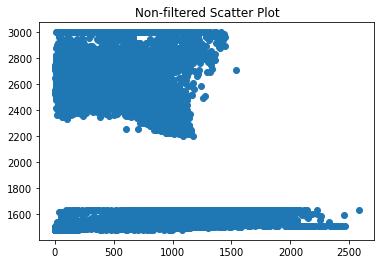

In [7]:
plt.scatter(m,s)
plt.title("Non-filtered Scatter Plot")
# plt.ylim(None,1800)

Text(0.5, 1.0, 'Filtered Scatter Plot')

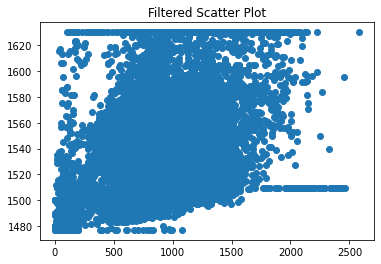

In [8]:
fil_m, fil_s = filter(m,s,[0,1800])
plt.scatter(fil_m, fil_s)
plt.title("Filtered Scatter Plot")

In [8]:
def create_sections(mri_im, sos_im, labels):
  [slice,y0,y1,x0,x1] = labels.split(',')
  temp_m = np.array(mri_im[:,:,int(slice)][int(y0):int(y1),int(x0):int(x1)])
  temp_s = np.array(sos_im[:,:,int(slice)][int(y0):int(y1),int(x0):int(x1)])

  return [temp_m, temp_s]

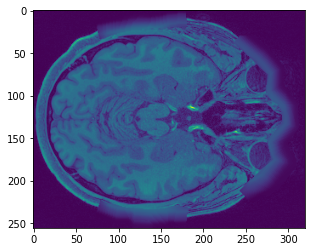

In [26]:
plt.imshow(mri_data[:,:,120])

In [41]:
# all image
n=0
slice = [i for i in range(130,220)]
sections = []
for s in slice:
    for n in range(0,int(mri_data.shape[0]/p.size)):
        for k in range(0,int(mri_data.shape[2]/p.size)):
            sections.append(create_sections(mri_data,sos_data,str(s)+","+str(n*p.size)+","+str(n*p.size+p.size)+','+str(k*p.size)+","+str(k*p.size+p.size)))
            
# just brain
brain_sections = []
for i in range(len(sections)):
    if(i%5==0 or (i-4)==5): continue
    else: brain_sections.append(sections[i])

print("Full dataset: " +str(np.array(sections).shape))
print("Brain-containing images: " +str(len(brain_sections)))

Full dataset: (1800, 2, 64, 64)
Brain-containing images: 1439


In [49]:
def save_models(G_A2B, G_B2A, D_A, D_B, name):

  torch.save(G_A2B, name+"_G_A2B.pt")
  torch.save(G_B2A,  name+"_G_B2A.pt")
  torch.save(D_A,  name+"_D_A.pt")
  torch.save(D_B, name+"_D_B.pt")

def load_models( name):

  G_A2B=torch.load(name+"_G_A2B.pt", map_location=torch.device('cpu'))
  G_B2A=torch.load(name+"_G_B2A.pt",map_location=torch.device('cpu'))
  D_A=torch.load(name+"_D_A.pt", map_location=torch.device('cpu'))
  D_B=torch.load(name+"_D_B.pt", map_location=torch.device('cpu'))
  return G_A2B, G_B2A, D_A, D_B

In [50]:
from ResnetGenerator import ResnetGenerator
from NLayerDiscriminator import NLayerDiscriminator

In [51]:
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

In [53]:
G_A2B = ResnetGenerator(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, padding_type='reflect').to(device)
G_B2A = ResnetGenerator(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, padding_type='reflect').to(device)
D_A = NLayerDiscriminator(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.n_channels, norm_layer=nn.BatchNorm2d).to(device)
D_B = NLayerDiscriminator(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.n_channels, norm_layer=nn.BatchNorm2d).to(device)
name = "try2"
# G_A2B, G_B2A, D_A, D_B= load_models(name)
# G_A2B.to(device)
# G_B2A.to(device)
# D_A.to(device)
# D_B.to(device)

# Initialize Loss function
criterion_Im = torch.nn.L1Loss() 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [54]:
def training(G_A2B, G_B2A, D_A, D_B,num_epochs,name,old = True):

  print(wandb.config)  

  # Training Loop

  # Lists to keep track of progress
  img_list = []
  G_losses = []
  D_A_losses = []
  D_B_losses = []


  iters=0
  FDL_A2B = []
  FDL_B2A = []
  CL_A = []
  CL_B = []
  ID_B2A = []
  ID_A2B = []
  disc_A = []
  disc_B = []


  FDL_A2B_t = []
  FDL_B2A_t = []
  CL_A_t = []
  CL_B_t = []
  ID_B2A_t = []
  ID_A2B_t = []
  disc_A_t = []
  disc_B_t = []

  print("Starting Training Loop...")
  # For each epoch
  for epoch in range(p.bs):

    # For each batch in the dataloader
    for b in range(len(sections)):
        # print(b)
        # Set model input
        a_real = torch.Tensor(sections[b][0]).unsqueeze(0).unsqueeze(0).to(device)
        b_real = torch.Tensor(sections[b][1]).unsqueeze(0).unsqueeze(0).to(device)
      
        tensor_ones=torch.ones([a_real.shape[0],1,14,14]).to(device)
        tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).to(device)

        # Generated images
        # print("a_real shape: "+str(a_real.shape))
        b_fake = G_A2B(a_real)
        # print("fake image generated")
        a_rec = G_B2A(b_fake)
        a_fake = G_B2A(b_real)
        b_rec = G_A2B(a_fake)

        # CALCULATE DISCRIMINATORS LOSSES
        # Discriminator A
        optimizer_D_A.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(1, old_a_fake.shape[0]-1)
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-1:rand_int].detach()))
          D_A_losses.append(Disc_loss_A.item())

        else:
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
          D_A_losses.append(Disc_loss_A.item())

        # Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
        # D_A_losses.append(Disc_loss_A.item())
        
        Disc_loss_A.backward()
        optimizer_D_A.step()

        
        # Discriminator B

        optimizer_D_B.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(1, old_b_fake.shape[0]-1)
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-1:rand_int].detach()))
          D_B_losses.append(Disc_loss_B.item())
        else:
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
          D_B_losses.append(Disc_loss_B.item())

        Disc_loss_B.backward()
        optimizer_D_B.step()   

        # Generator

        optimizer_G_A2B.zero_grad()
        optimizer_G_B2A.zero_grad()


        # CALCULATE GENERATORS LOSSES
        Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
        Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

        # Cycle Consistency    both use the two generators
        Cycle_loss_A = criterion_Im(a_rec, a_real)*5
        Cycle_loss_B = criterion_Im(b_rec, b_real)*5

        # Identity loss
        Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
        Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

        # generator losses
        Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
        G_losses.append(Loss_G)

        wandb.log({
            "disc_loss_A2B": Fool_disc_loss_A2B,
            "disc_loss_B2A": Fool_disc_loss_B2A,
            "Cycle_loss_A": Cycle_loss_A,
            "Cycle_loss_B": Cycle_loss_B,
            "id_loss_A2B": Id_loss_A2B,
            "id_loss_B2A": Id_loss_B2A,
            "total_g": Loss_G,
            "total_d": Fool_disc_loss_A2B + Fool_disc_loss_B2A
        })

        # Backward propagation
        Loss_G.backward()
        
        
        # Optimisation step
        optimizer_G_A2B.step()
        optimizer_G_B2A.step()

        FDL_A2B.append(Fool_disc_loss_A2B)
        FDL_B2A.append(Fool_disc_loss_B2A)
        CL_A.append(Cycle_loss_A)
        CL_B.append(Cycle_loss_B)
        ID_B2A.append(Id_loss_B2A)
        ID_A2B.append(Id_loss_A2B)
        disc_A.append(Disc_loss_A)
        disc_B.append(Disc_loss_B)

        if(iters == 0 and epoch == 0):
          old_b_fake = b_fake.clone()
          old_a_fake = a_fake.clone()
        elif (old_b_fake.shape[0] == p.bs*5 and b_fake.shape[0]==p.bs):
          rand_int = random.randint(5, 24)
          old_b_fake[rand_int-5:rand_int] = b_fake.clone()
          old_a_fake[rand_int-5:rand_int] = a_fake.clone()
        elif(old_b_fake.shape[0]< 25):
          old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
          old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

        iters += 1
        del a_real, b_real, a_fake, b_fake


        if iters % 50 == 0:
      
          print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                          Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
          # print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
          #             % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B, Disc_loss_A.item(), Disc_loss_B.item()))
        

    FDL_A2B_t.append(sum(FDL_A2B)/len(FDL_A2B))
    FDL_B2A_t.append(sum(FDL_B2A)/len(FDL_B2A))
    CL_A_t.append(sum(CL_A)/len(CL_A))
    CL_B_t.append(sum(CL_B)/len(CL_B))
    ID_B2A_t.append(sum(ID_B2A)/len(ID_B2A))
    ID_A2B_t.append(sum(ID_A2B)/len(ID_A2B))
    disc_A_t.append(sum(disc_A)/len(disc_A))
    disc_B_t.append(sum(disc_B)/len(disc_B))

    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_B = []
    disc_A = []

    iters = 0             
    save_models(G_A2B, G_B2A, D_A, D_B, name)
    # if (epoch % 5 == 0):
    #   plot_images_test(dataloader_vangogh, dataloader_photo)
    # plot_all_images(4, dataloader_vangogh, dataloader_photo)
  return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,ID_B2A_t,ID_A2B_t,disc_A_t,disc_B_t)

In [55]:
# !pip install wandb
import wandb

In [56]:
wandb.init(project="mri2sos-patches", entity="clara_rg_")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: clara_rg_ (use `wandb login --relogin` to force relogin)


In [57]:
wandb.config = {
    "learning_rate": lr,
    "epochs": 20,
    "betas": (beta1, 0.999),
    "G_A2B_params": G_A2B.parameters(),
    "G_B2A_params": G_B2A.parameters(),
    "D_A_params": D_A.parameters(),
    "D_B_params": D_B.parameters(),
    "params": p
}

In [58]:
epochs=20
netG_A2B, netG_B2A, netD_A, netD_B=G_A2B, G_B2A, D_A, D_B

optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=lr, betas=(beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

losses = training( netG_A2B, netG_B2A, netD_A, netD_B,epochs,name)

{'learning_rate': 0.0002, 'epochs': 20, 'betas': (0.5, 0.999), 'G_A2B_params': <generator object Module.parameters at 0x0000021194AA7C10>, 'G_B2A_params': <generator object Module.parameters at 0x0000021194AC8900>, 'D_A_params': <generator object Module.parameters at 0x0000021194AC8E40>, 'D_B_params': <generator object Module.parameters at 0x0000021194AC8EB0>, 'params': Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=6, dis_n_down=2)}
Starting Training Loop...
[1/20]	FDL_A2B: 0.7878	FDL_B2A: 0.5638	CL_A: 2404.8020	CL_B: 8539.0312	ID_B2A: 4809.6885	ID_A2B: 17078.0684	Loss_D_A: 0.1612	Loss_D_A: 0.2048
[1/20]	FDL_A2B: 1.0217	FDL_B2A: 0.7707	CL_A: 630.2772	CL_B: 7561.9971	ID_B2A: 1260.8774	ID_A2B: 15123.9395	Loss_D_A: 0.7486	Loss_D_A: 0.0317
[1/20]	FDL_A2B: 1.0012	FDL_B2A: 0.8765	CL_A: 2488.7737	CL_B: 8714.2969	ID_B2A: 4977.5464	ID_A2B: 17428.5898	Loss_D_A: 0.0445	Loss_D_A: 0.0071
[1/20]	FDL_A2B: 0.9818	FDL_B2A: 1.1719	CL_A: 715.9967	CL_B: 7585.3330	ID_B2

KeyboardInterrupt: 

In [15]:
mri_test_file = glob(r"C:\Users\Xiaowei\Documents\MRI_Vols\100206\m100206_T1w.nii.gz")[0]
mri_im = nb.load(mri_file)
mri_test_data = mri_im.get_fdata()

sos_test_file = glob(r"C:\Users\Xiaowei\Documents\MRI_Vols\100206\Vp.nii.gz")[0]
sos_im = nb.load(sos_file)
sos_test_data = sos_im.get_fdata()

n=0
slice = [180]
test_sections = []
for s in slice:
    for n in range(0,int(mri_data.shape[0]/p.size)):
        for k in range(0,int(mri_data.shape[2]/p.size)):
            test_sections.append(create_sections(mri_data,sos_data,str(s)+","+str(n*p.size)+","+str(n*p.size+p.size)+','+str(k*p.size)+","+str(k*p.size+p.size)))

np.array(sections).shape

(1800, 2, 64, 64)

In [16]:
b_fake = []
for i in range(len(test_sections)):
    b_fake.append(G_A2B(torch.Tensor(test_sections[i][0]).unsqueeze(0).unsqueeze(0).to(device)))

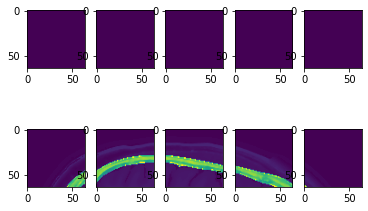

In [20]:
plt.subplots(2,5)
plot=1
for i in range(5):
    plt.subplot(2,5,plot)
    plt.imshow(b_fake[i].cpu().detach().numpy()[0,0,:,:])
    plt.subplot(2,5,plot+5)
    plt.imshow(np.array(test_sections[i][1]))
    plot +=1

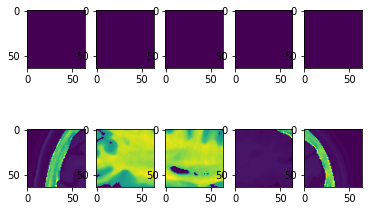

In [21]:
plt.subplots(2,5)
plot=1
for i in range(5,10):
    plt.subplot(2,5,plot)
    plt.imshow(b_fake[i].cpu().detach().numpy()[0,0,:,:])
    plt.subplot(2,5,plot+5)
    plt.imshow(np.array(test_sections[i][1]))
    plot +=1

ValueError: num must be 1 <= num <= 20, not 21

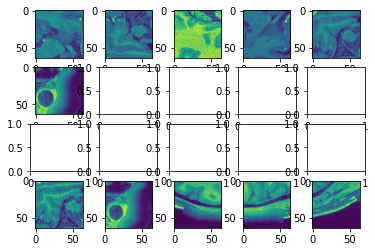

In [48]:
plt.subplots(4,5)
plot=1
for i in range(5,20):
    plt.subplot(4,5,plot)
    plt.imshow(brain_sections[i][0])
    plt.subplot(4,5,plot+15)
    plt.imshow(brain_sections[i+20][0])
    plot +=1

In [25]:
b_fake[i].cpu().detach().numpy()

array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]]], dtype=float32)

In [54]:
class FML(nn.Module):
  def __init__(self):
    super(FML, self).__init__()
    seq = [nn.ReflectionPad2d(3),
                 nn.Conv2d(1, 64, kernel_size=7, padding=1, bias=1)]
                #  nn.BatchNorm2d(64),
                #  nn.ReLU(True)]
    self.model = nn.Sequential(*seq)

  def forward(self, input):
    return self.model(input)

In [ ]:
a_real = torch.Tensor(sections[9][0]).unsqueeze(0).unsqueeze(0).to(device)
# Generated images
b_fake = G_A2B(a_real)
print("fake image generated")

In [114]:
print(torch.Tensor(sections[8][1]).unsqueeze(0).unsqueeze(0).shape)
print(torch.Tensor(sections[0][0]).unsqueeze(0).unsqueeze(0).shape)

torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])


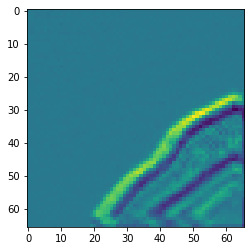

In [55]:
basic = FML().to(device)
a_fake = basic(mri)[0]
plt.imshow(a_fake.cpu().detach().numpy()[0,:,:])

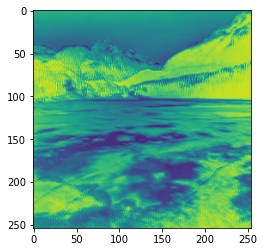

In [147]:
c = nn.Conv2d(3,3,3)
plt.imshow(c(b_real).detach().numpy()[0,0,:,:])

0
(64, 64)
1
(64, 64)
2
(64, 64)
3
(64, 64)
4
(64, 64)
5
(64, 64)
6
(64, 64)
7
(64, 64)
8
(64, 64)
9
(64, 64)
10
(64, 64)
11
(64, 64)
12
(64, 64)
13
(64, 64)
14
(64, 64)
15
(64, 64)
16
(64, 64)
17
(64, 64)
18
(64, 64)
19
(64, 64)


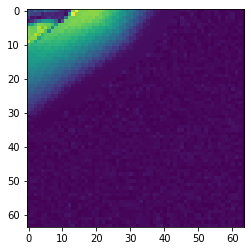

In [194]:
for i in range(len(sections)):
    print(i)
    print(sections[i][0].shape)
# create_sections(mri_data, sos_data, str(150)+","+str(256)+","+str(320)+','+str(0)+","+str(64))
# print(mri_data.shape)
plt.imshow(np.array(sections[19][0]))

In [31]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     864 MB |     913 MB |    1065 MB |  205143 KB |
|       from large pool |     843 MB |     892 MB |    1032 MB |  193681 KB |
|       from small pool |      21 MB |      22 MB |      32 MB |   11462 KB |
|---------------------------------------------------------------------------|
| Active memory         |     864 MB |     913 MB |    1065 MB |  205143 KB |
|       from large pool |     843 MB |     892 MB |    1032 MB |

In [18]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_summary())

37708800
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   36825 KB |   36825 KB |   41442 KB |    4617 KB |
|       from large pool |   20480 KB |   20480 KB |   20480 KB |       0 KB |
|       from small pool |   16345 KB |   16345 KB |   20962 KB |    4617 KB |
|---------------------------------------------------------------------------|
| Active memory         |   36825 KB |   36825 KB |   41442 KB |    4617 KB |
|       from large pool |   20480 KB |   20480 KB |   2

In [19]:
G_A2B.cpu()
print(torch.cuda.memory_allocated())

29926400
